# Experimentos y análisis


In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
import os

CONVEX_HULL_EXEC = "../build/structures"


In [9]:

rnge = 60000.0
pcnt = 0.0
size = 0
for i in range(2000):
    size += 500
    print("Running for size", size)
    # do 10 runs for each size
    for _ in range(5):
        subprocess.run([CONVEX_HULL_EXEC, "1", str(size), str(rnge), str(pcnt)], stdout=subprocess.DEVNULL)

Running for size 552500
Running for size 553000
Running for size 553500
Running for size 554000
Running for size 554500
Running for size 555000
Running for size 555500
Running for size 556000
Running for size 556500
Running for size 557000
Running for size 557500
Running for size 558000
Running for size 558500
Running for size 559000
Running for size 559500
Running for size 560000
Running for size 560500
Running for size 561000
Running for size 561500
Running for size 562000
Running for size 562500
Running for size 563000
Running for size 563500
Running for size 564000
Running for size 564500
Running for size 565000
Running for size 565500
Running for size 566000
Running for size 566500
Running for size 567000
Running for size 567500
Running for size 568000
Running for size 568500
Running for size 569000
Running for size 569500
Running for size 570000
Running for size 570500
Running for size 571000
Running for size 571500
Running for size 572000
Running for size 572500
Running for size

KeyboardInterrupt: 

In [1]:
rnge = 60000.0
for i in range(1, 7):
    pcnt = 0.1
    size = 10**i
    print("Running for size", size)
    # do 10 runs for each size
    for _ in range(10):
        for _ in range(10):
            subprocess.run([CONVEX_HULL_EXEC, "2", str(size), str(rnge), str(pcnt)], stdout=subprocess.DEVNULL)
        pcnt+=0.1

Running for size 10000000


NameError: name 'subprocess' is not defined

### Análisis

In [5]:
random_points_gw = pd.read_csv("random_point_gw.csv", header=None)
random_points_in = pd.read_csv("random_point_in.csv", header=None)
compare_random_pols = pd.read_csv("comparison_random_pnts_file.csv", header=None)

random_points_gw_columns = ["size", "minx_search_time", "cross prods time", "total time", "hull size"]
random_points_in_columns = ["size", "sorting time", "lower hull time", "upper hull size", "total time", "hull size"]
compare_random_pols_columns = ["size", "gs hull size", "in hull size", "equality"]
random_points_gw.columns = random_points_gw_columns
random_points_in.columns = random_points_in_columns
compare_random_pols.columns = compare_random_pols_columns
random_points_gw["equality"] = compare_random_pols["equality"]
random_points_in["equality"] = compare_random_pols["equality"]

circ_points_gw = pd.read_csv("circle_point_gw.csv", header=None)
circ_points_in = pd.read_csv("circle_point_in.csv", header=None)
compare_circ_pols = pd.read_csv("comparison_circ_pnts_file.csv", header=None)

circ_points_gw_columns = ["size", "minx_search_time", "cross prods time", "total time", "hull size"]
circ_points_in_columns = ["size", "sorting time", "lower hull time", "upper hull size", "total time", "hull size"]
compare_circ_pols_columns = ["size", "gs hull size", "in hull size", "pcnt points in hull", "equality"]
circ_points_gw.columns = circ_points_gw_columns
circ_points_in.columns = circ_points_in_columns
compare_circ_pols.columns = compare_circ_pols_columns
circ_points_gw["equality"] = compare_circ_pols["equality"]
circ_points_in["equality"] = compare_circ_pols["equality"]
circ_points_gw["pcnt points in hull"] = compare_circ_pols["pcnt points in hull"]
circ_points_in["pcnt points in hull"] = compare_circ_pols["pcnt points in hull"]


In [6]:
# checking methods produced equal poligons
random_points_gw_filtered = random_points_gw.query('`equality` == 1')
random_points_in_filtered = random_points_in.query('`equality` == 1')

print("Checking equality on results for random clouds:", random_points_gw_filtered.size == random_points_gw.size, random_points_in_filtered.size == random_points_in.size)

circ_points_gw_filtered = circ_points_gw.query('`equality` == 1')
circ_points_in_filtered = circ_points_in.query('`equality` == 1')

print("Checking equality on results for hull-on-circle clouds:", circ_points_gw_filtered.size == circ_points_gw.size, circ_points_in_filtered.size == circ_points_in.size)

Checking equality on results for random clouds: True True
Checking equality on results for hull-on-circle clouds: False False


In [30]:
random_points_gw["hull total size ratio"] = random_points_gw["hull size"]/random_points_gw["size"]
random_points_in["hull total size ratio"] = random_points_in["hull size"]/random_points_in["size"]

print("Promedio de puntos en el hull con respecto al total de puntos (nubes aleatorias) en GW:",random_points_gw.mean()["hull total size ratio"])
print("Promedio de puntos en el hull con respecto al total de puntos (nubes aleatorias) en In:",random_points_in.mean()["hull total size ratio"])

circ_points_gw["hull total size ratio"] = circ_points_gw["hull size"]/circ_points_gw["size"]
circ_points_in["hull total size ratio"] = circ_points_in["hull size"]/circ_points_in["size"]

print("Promedio de puntos en el hull con respecto al total de puntos (nubes controladas) en GW:\n",circ_points_gw.query('`size` == 100000').groupby("pcnt points in hull").mean()["hull total size ratio"])
print("Promedio de puntos en el hull con respecto al total de puntos (nubes controladas) en In:\n",circ_points_in.query('`size` == 100000').groupby("pcnt points in hull").mean()["hull total size ratio"])
print("#################################")
print("El porcentaje de puntos en el hull con respecto al total de puntos para tamaño 10^6 no es siempre el indicado por el porcentaje dado.")

Promedio de puntos en el hull con respecto al total de puntos (nubes aleatorias) en GW: 0.0007983228613935483
Promedio de puntos en el hull con respecto al total de puntos (nubes aleatorias) en In: 0.0007983228613935483
Promedio de puntos en el hull con respecto al total de puntos (nubes controladas) en GW:
 pcnt points in hull
0.1    0.10000
0.2    0.19696
0.3    0.23889
0.4    0.25811
0.5    0.27383
0.6    0.29290
0.7    0.30060
0.8    0.31425
0.9    0.32487
1.0    0.33002
Name: hull total size ratio, dtype: float64
Promedio de puntos en el hull con respecto al total de puntos (nubes controladas) en In:
 pcnt points in hull
0.1    0.10000
0.2    0.19696
0.3    0.23889
0.4    0.25811
0.5    0.27383
0.6    0.29290
0.7    0.30060
0.8    0.31422
0.9    0.32488
1.0    0.33002
Name: hull total size ratio, dtype: float64
#################################
El porcentaje de puntos en el hull con respecto al total de puntos para tamaño 10^6 no es siempre el indicado por el porcentaje dado.


# Comparación del desempeño de los Algoritmos

### Nubes de Puntos Aleatorias

Primero se realizará una visualización general del promedio del tiempo total que toman los algoritmos según el tamaño de las nubes de puntos entregadas para obtener su cerradura convexa.

          sorting time  lower hull time  upper hull size     total time  \
size                                                                      
10            1.200000         0.000000         0.000000       1.200000   
100          20.000000         5.200000         4.800000      30.000000   
1000        257.133333        46.666667        45.666667     349.466667   
1500        356.600000        60.000000        59.400000     476.000000   
2000        486.400000        86.800000        80.600000     653.800000   
...                ...              ...              ...            ...   
998500   431568.200000     32917.400000     34324.200000  498809.800000   
999000   421130.000000     33026.600000     34527.400000  488684.000000   
999500   417989.200000     34625.400000     32339.400000  484954.000000   
1000000  445878.733333     33131.933333     34643.400000  513654.066667   
1000500  413428.333333     31235.666667     31337.666667  476001.666667   

         hull size  equa

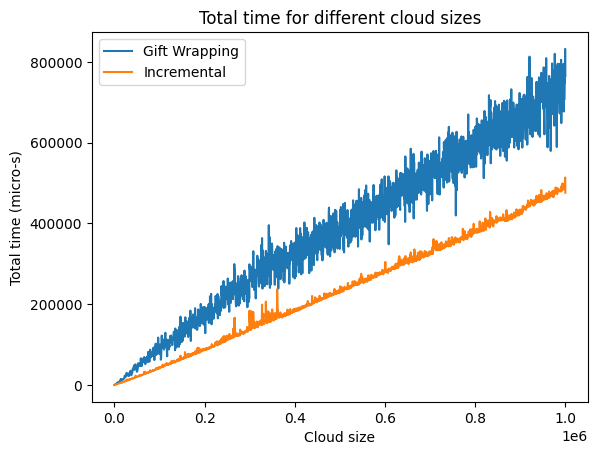

In [7]:
### Puntos Aleatorios para Hull

# plot avg total time for each size
random_points_gw_avg = random_points_gw.groupby("size").mean()
random_points_in_avg = random_points_in.groupby("size").mean()
print(random_points_in_avg)


fig, ax = plt.subplots()
ax.plot(random_points_gw_avg.index, random_points_gw_avg["total time"], label="Gift Wrapping")
ax.plot(random_points_in_avg.index, random_points_in_avg["total time"], label="Incremental")
ax.set_xlabel("Cloud size")
ax.set_ylabel("Total time (micro-s)")
ax.legend()
# plt.xscale('log', base=10)
plt.title("Total time for different cloud sizes")
plt.show()

Ahora se colocará la comparación en gráficos de barra, una representando el algoritmo de Gift Wrapping (azul) y otra el algoritmo Incremental (rojo).

C:\Users\ThermalTake\AppData\Local\Temp\ipykernel_20036\1105470682.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  random_points_gw_grouped_data = random_points_gw.groupby(bins)['total time'].mean()
C:\Users\ThermalTake\AppData\Local\Temp\ipykernel_20036\1105470682.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  random_points_in_grouped_data = random_points_in.groupby(bins)['total time'].mean()


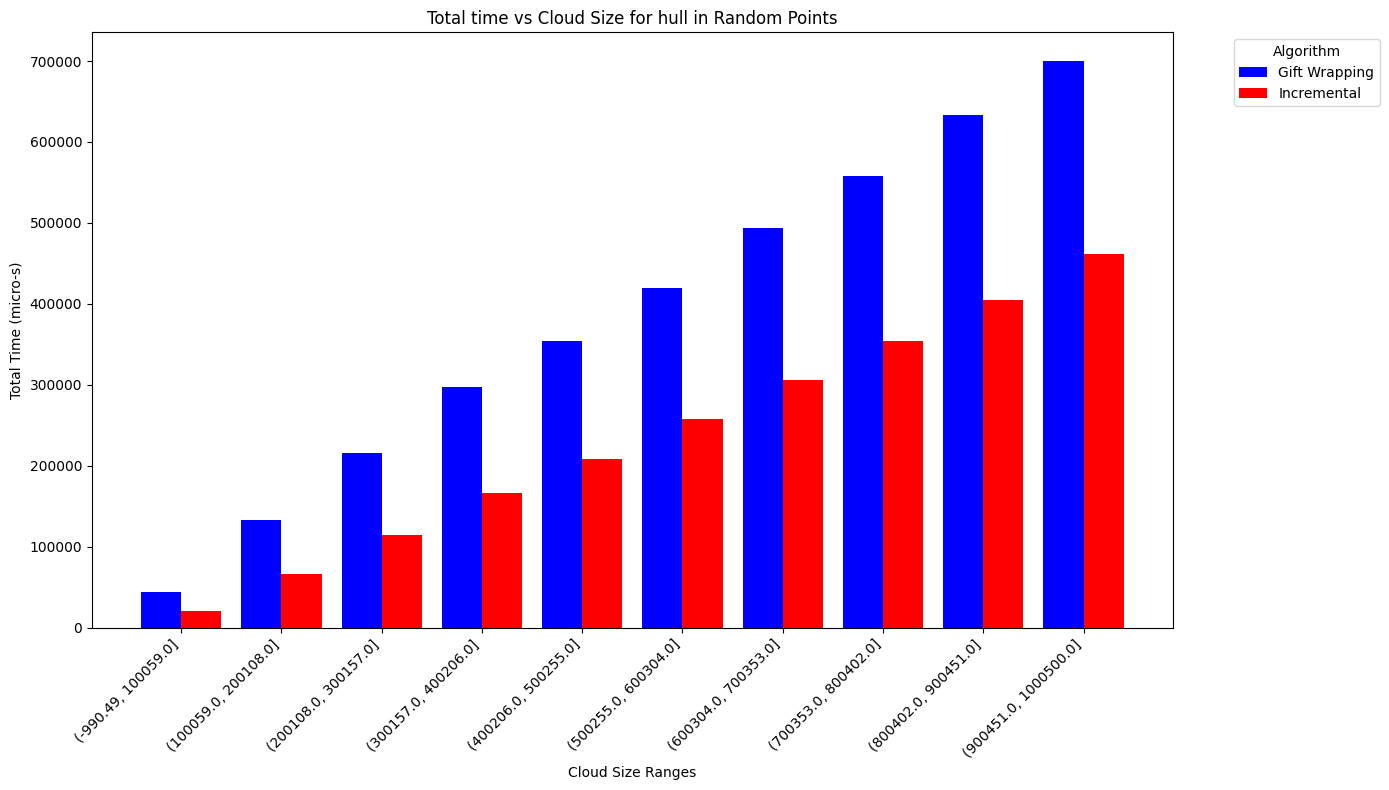

In [13]:
bins = pd.cut(random_points_gw['size'], bins=10)  # Ajusta el número de bins según sea necesario

# Agrupar por intervalos de tamaños y calcular el promedio del tiempo total
random_points_gw_grouped_data = random_points_gw.groupby(bins)['total time'].mean()
random_points_in_grouped_data = random_points_in.groupby(bins)['total time'].mean()

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.4  # Ancho de las barras

# Posiciones de las barras en el eje x
x = np.arange(len(random_points_gw_grouped_data.index))

# Dibujar las barras
ax.bar(x - width/2, random_points_gw_grouped_data, width, color="blue", label="Gift Wrapping")
ax.bar(x + width/2, random_points_in_grouped_data, width, color="red", label="Incremental")

# Ajustar las etiquetas y el formato del eje x
ax.set_xlabel("Cloud Size Ranges")
ax.set_ylabel("Total Time (micro-s)")
ax.set_title("Total time vs Cloud Size for hull in Random Points")
ax.set_xticks(x)
ax.set_xticklabels(random_points_gw_grouped_data.index, rotation=45, ha='right')
ax.legend(title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Nubes de Puntos con un Porcentaje de ellos en la cerradura

Se muestra un gráfico de líneas en que se compara los tiempos totales promedio de los algoritmos. No se separa por desempeño según el porcentaje de puntos que se colocó en el hull.

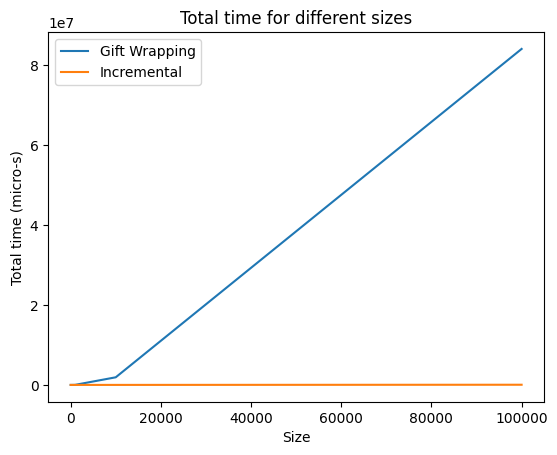

In [12]:
### Puntos Con Hull En Circunferencia

# plot avg total time for each size
circ_points_gw_avg = circ_points_gw.groupby("size").mean()
circ_points_in_avg = circ_points_in.groupby("size").mean()


fig, ax = plt.subplots()
ax.plot(circ_points_gw_avg.index, circ_points_gw_avg["total time"], label="Gift Wrapping")
ax.plot(circ_points_in_avg.index, circ_points_in_avg["total time"], label="Incremental")
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s)")
ax.legend()
# plt.yscale('log', base=2)
# plt.xscale('log', base=2)
plt.title("Total time for different sizes")
plt.show()

# Desempeño de algoritmos según el porcentaje de puntos en una circunferencia (parte del hull)

Se muestran 10 lineas: cada vez se agrega un 10% más de los puntos de la nube a la circunferencia que se supone formará la cerradura

### Para el algoritmo de Gift Wrapping 

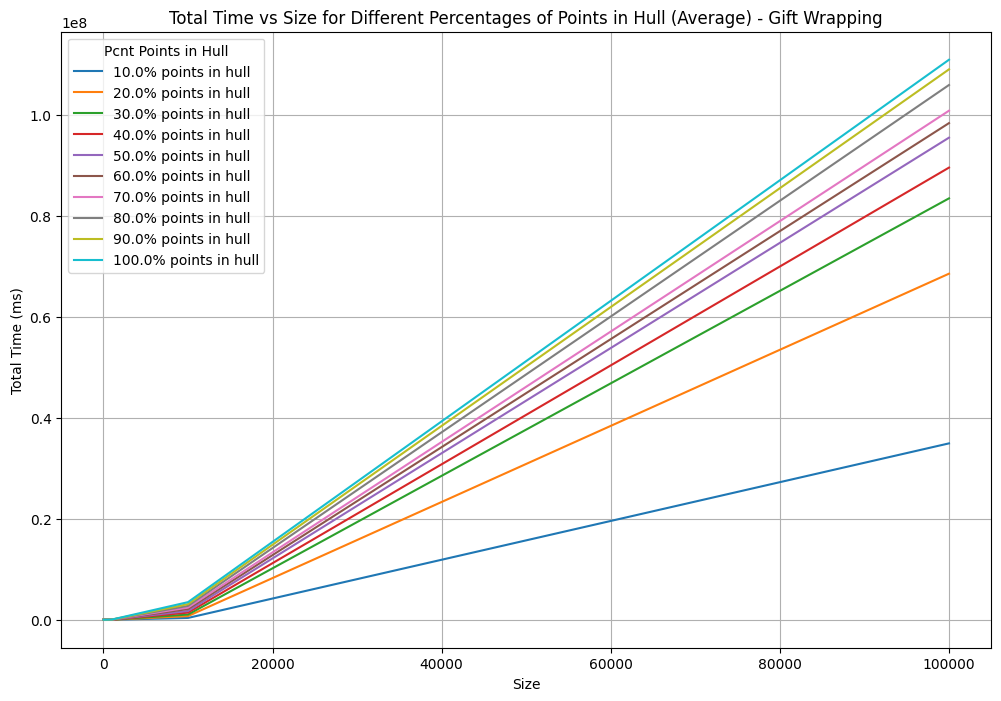

In [14]:
circ_points_pcnt_gw_avg = circ_points_gw.groupby(["size", "pcnt points in hull"]).mean().reset_index()

# Crear una figura y un eje
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graficar las líneas del tiempo total promedio para cada porcentaje
for pcnt in circ_points_pcnt_gw_avg["pcnt points in hull"].unique():
    subset = circ_points_pcnt_gw_avg[circ_points_pcnt_gw_avg["pcnt points in hull"] == pcnt]
    ax1.plot(subset["size"], subset["total time"], label=f"{pcnt*100}% points in hull")

# Configurar las etiquetas y el título del gráfico
ax1.set_xlabel("Size")
ax1.set_ylabel("Total Time (ms)")
ax1.set_title("Total Time vs Size for Different Percentages of Points in Hull (Average) - Gift Wrapping")
ax1.legend(title="Pcnt Points in Hull")
ax1.grid(True)

# Mostrar la figura}

plt.show()

#### Visualización en gráfico de barras.

Puede que sea una representación más visual de esta manera. Además se coloca el eje y en escala logarítmica pues de otra manera no se logra apreciar.

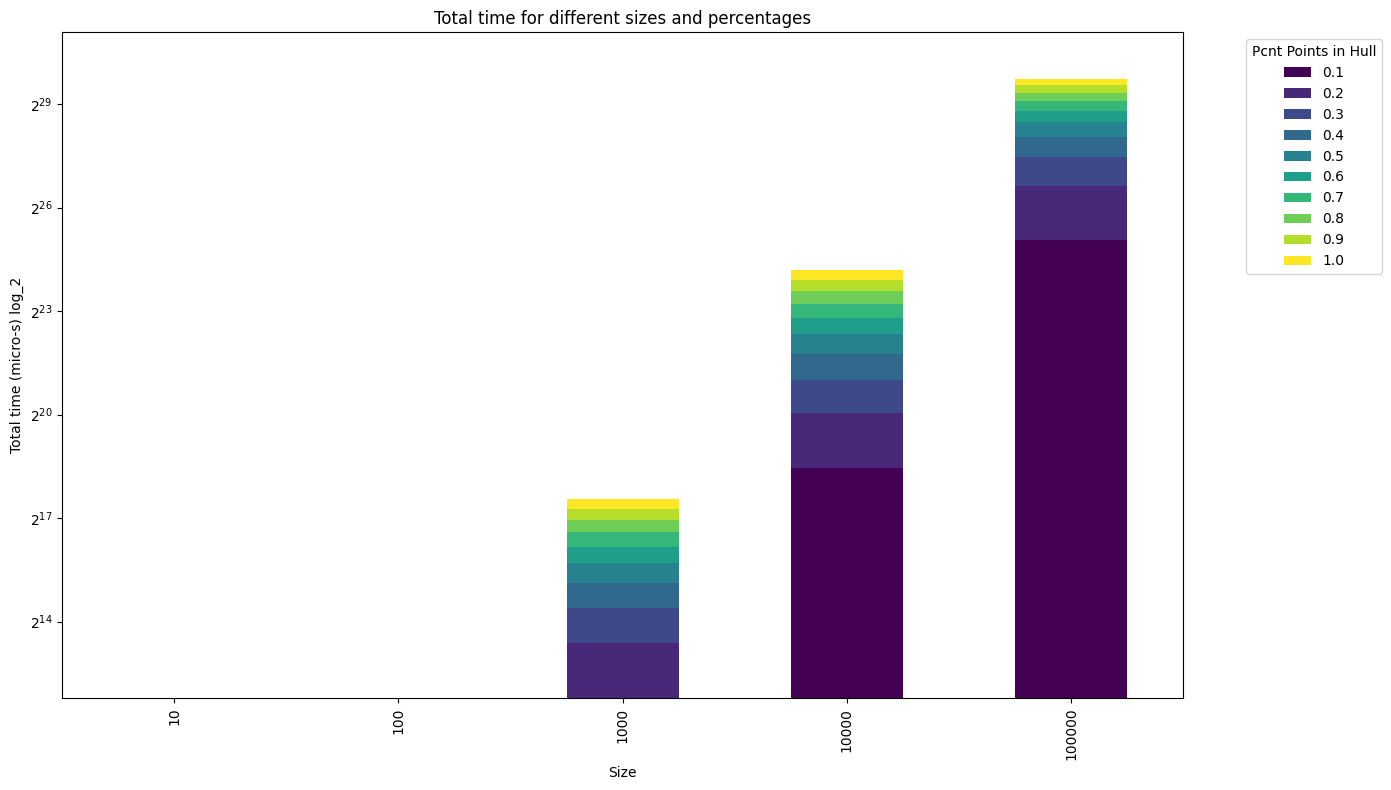

In [17]:
# Agrupar por tamaño y porcentaje y calcular los promedios
circ_points_gw_pcnt_avg = circ_points_gw.groupby(["size", "pcnt points in hull"]).mean().reset_index()

# Pivotar los datos para el gráfico de barras apiladas
pivot_df = circ_points_gw_pcnt_avg.pivot(index='size', columns='pcnt points in hull', values='total time')

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(14, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Ajustar las etiquetas y el formato del eje x
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s) log_2")
ax.set_title("Total time for different sizes and percentages")
ax.legend(title="Pcnt Points in Hull", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log', base=2)
plt.tight_layout()
plt.show()

### Para el algoritmo Incremental

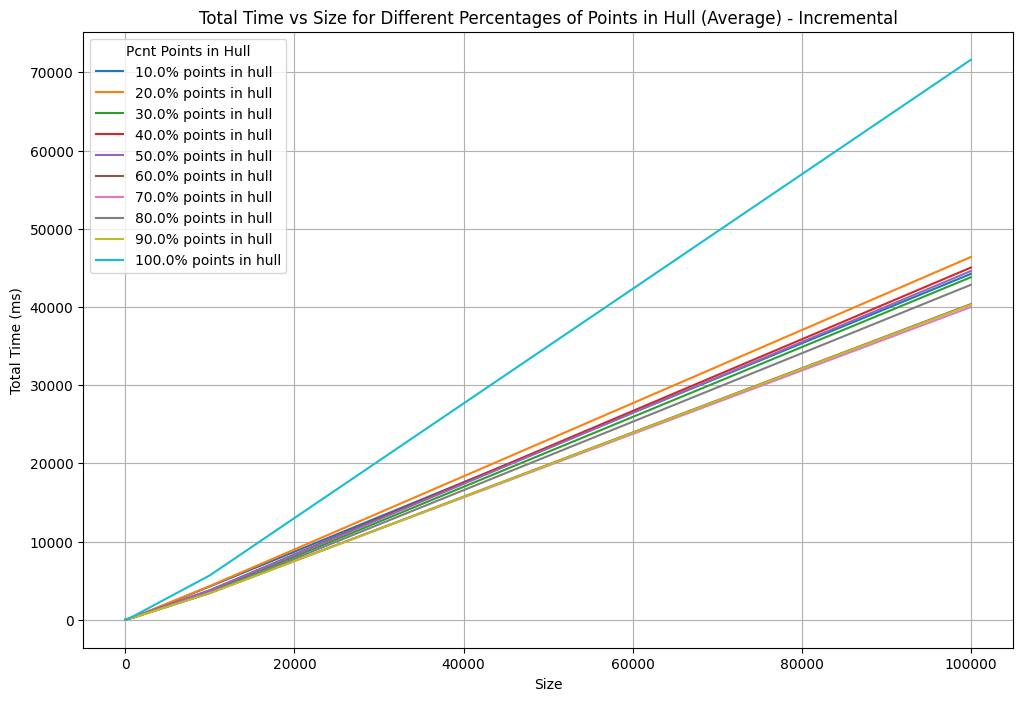

In [51]:
circ_points_pcnt_in_avg = circ_points_in.groupby(["size", "pcnt points in hull"]).mean().reset_index()

# Crear una figura y un eje
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graficar las líneas del tiempo total promedio para cada porcentaje
for pcnt in circ_points_pcnt_in_avg["pcnt points in hull"].unique():
    subset = circ_points_pcnt_in_avg[circ_points_pcnt_in_avg["pcnt points in hull"] == pcnt]
    ax1.plot(subset["size"], subset["total time"], label=f"{pcnt*100}% points in hull")

# Configurar las etiquetas y el título del gráfico
ax1.set_xlabel("Size")
ax1.set_ylabel("Total Time (ms)")
ax1.set_title("Total Time vs Size for Different Percentages of Points in Hull (Average) - Incremental")
ax1.legend(title="Pcnt Points in Hull")
ax1.grid(True)

# Mostrar la figura}

plt.show()

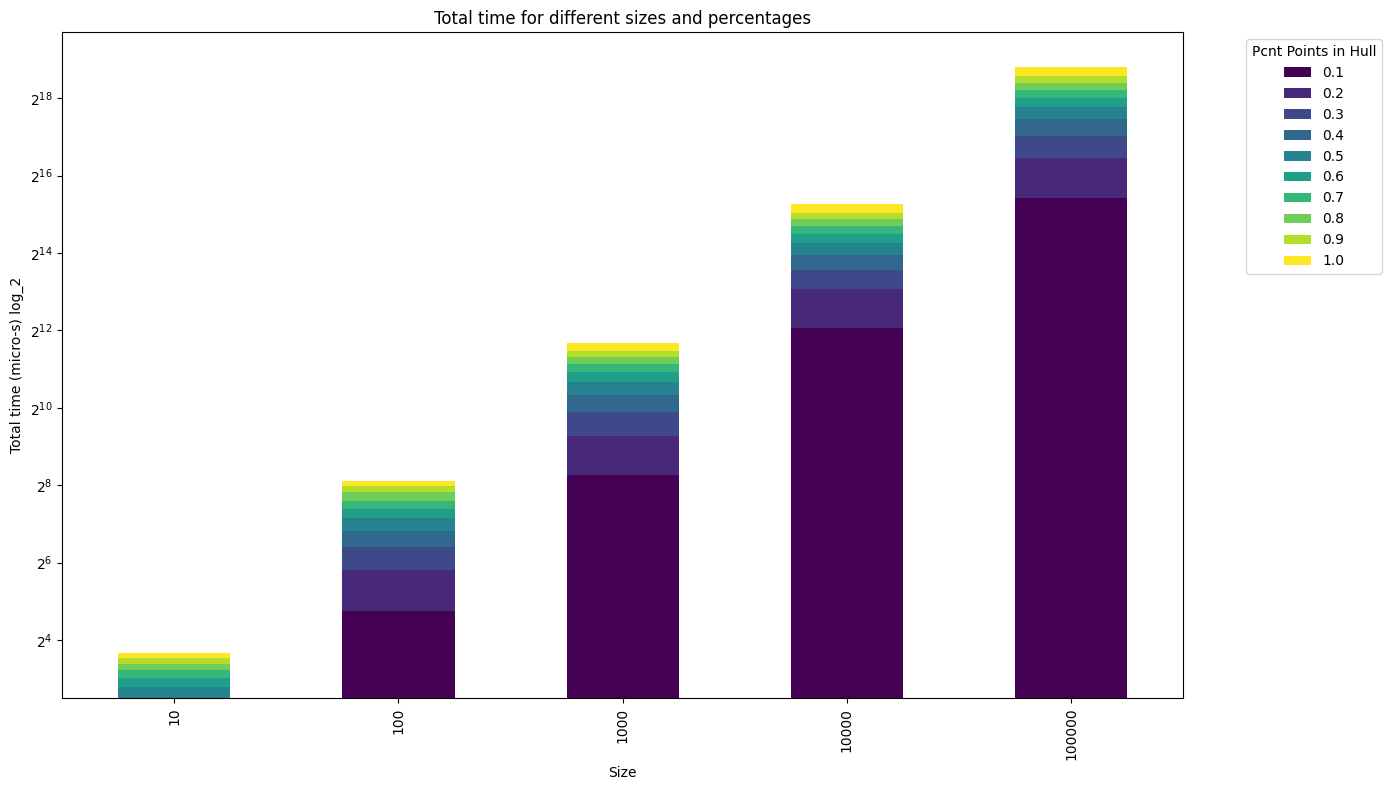

In [16]:
# Agrupar por tamaño y porcentaje y calcular los promedios
circ_points_in_pcnt_avg = circ_points_in.groupby(["size", "pcnt points in hull"]).mean().reset_index()

# Pivotar los datos para el gráfico de barras apiladas
pivot_df = circ_points_in_pcnt_avg.pivot(index='size', columns='pcnt points in hull', values='total time')

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(14, 8))
pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Ajustar las etiquetas y el formato del eje x
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s) log_2")
ax.set_title("Total time for different sizes and percentages")
ax.legend(title="Pcnt Points in Hull", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale('log', base=2)
plt.tight_layout()
plt.show()

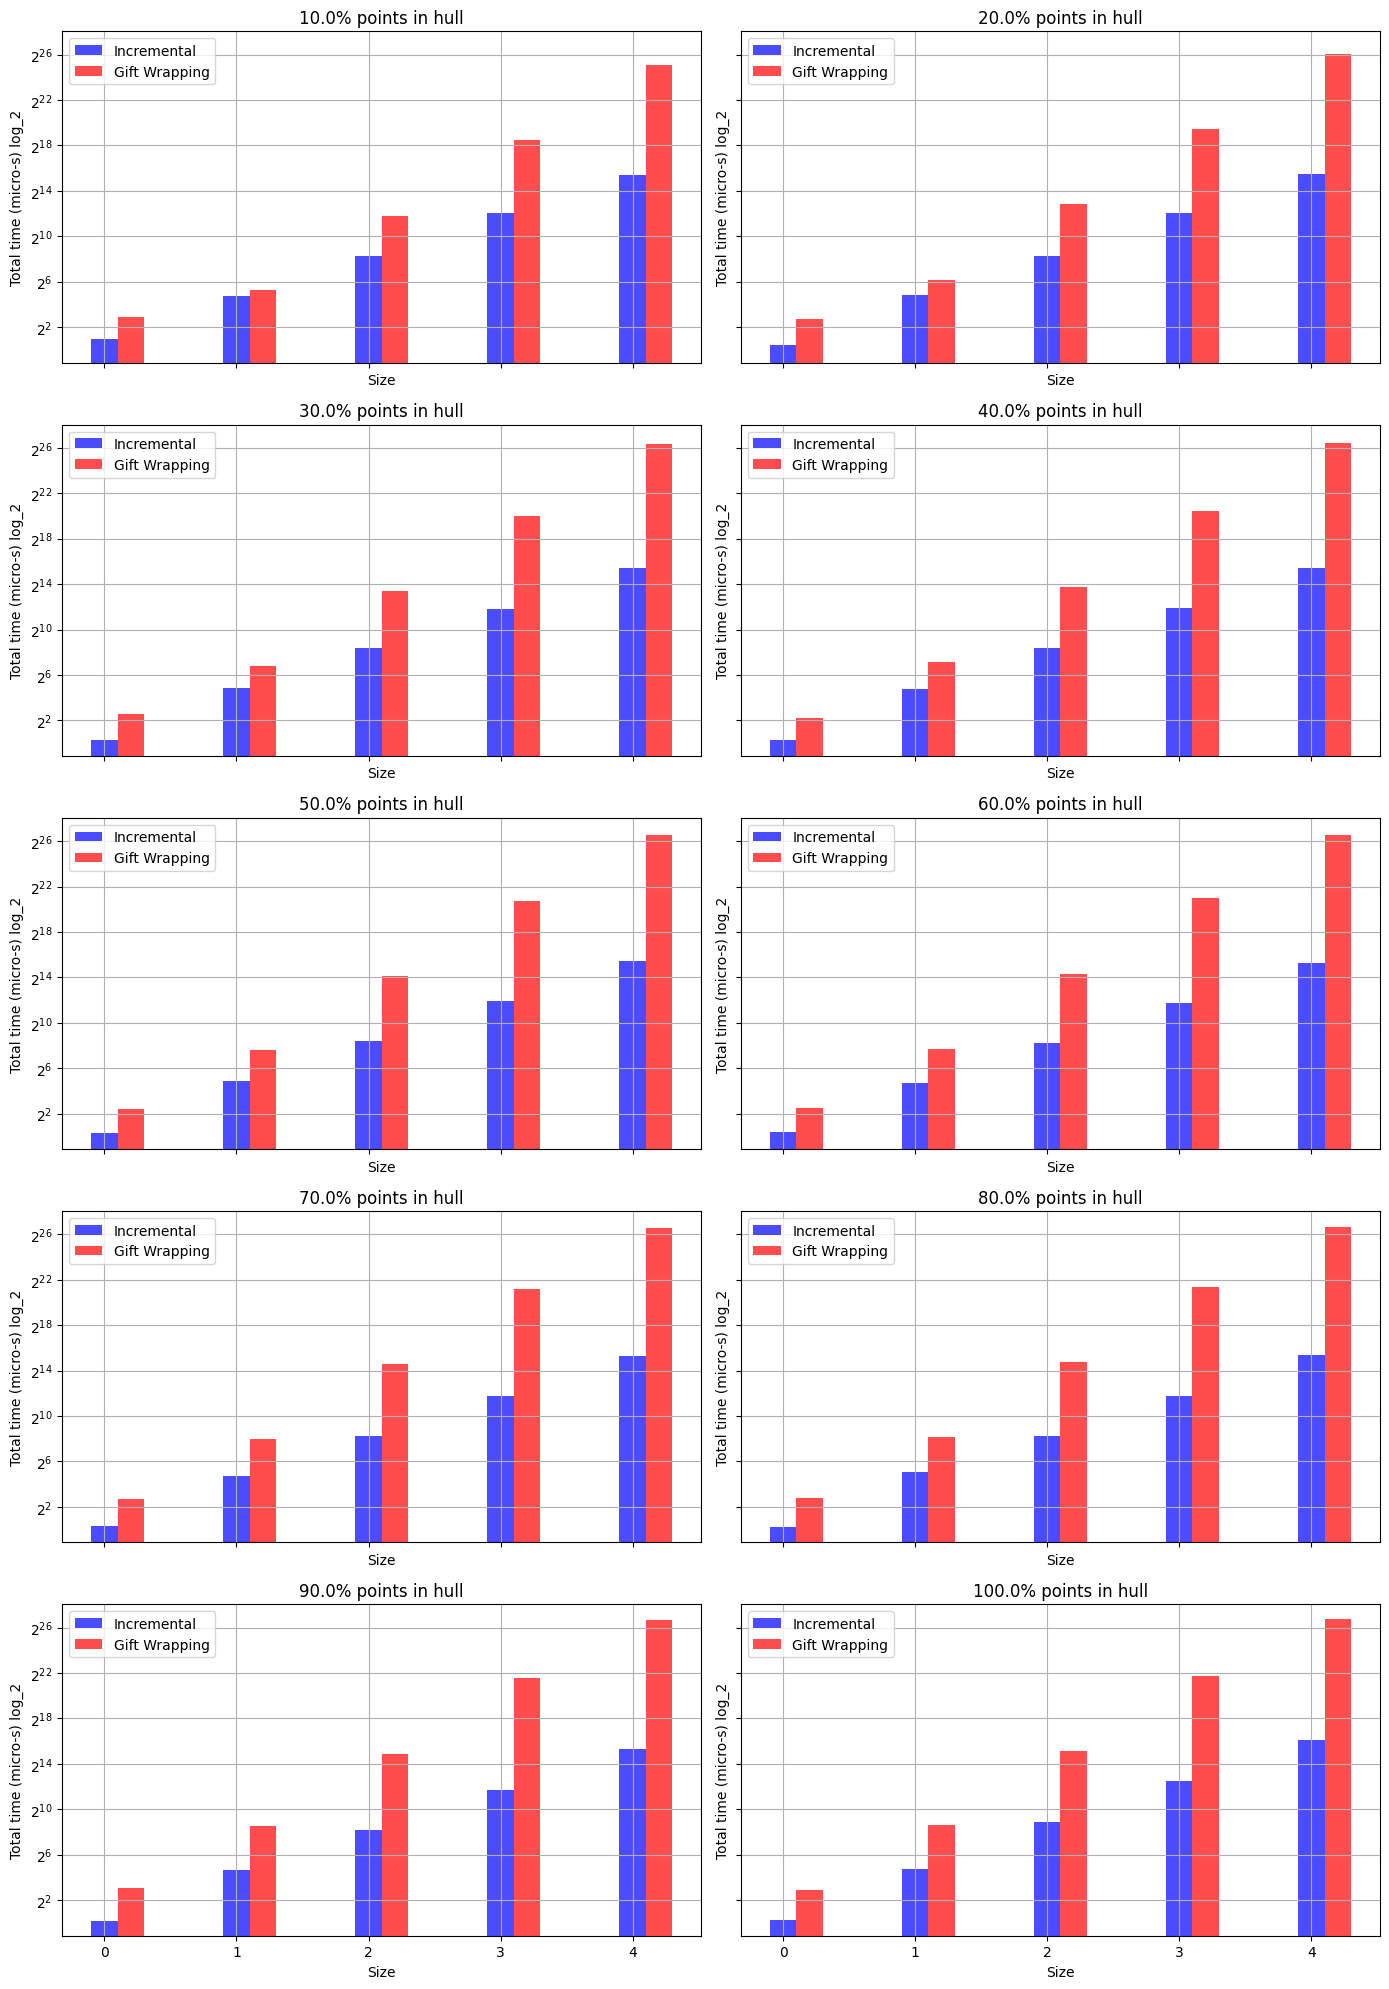

In [18]:
# Agrupar por tamaño y porcentaje y calcular los promedios
circ_points_gw_pcnt_avg = circ_points_gw.groupby(["size", "pcnt points in hull"]).mean().reset_index()
circ_points_in_pcnt_avg = circ_points_in.groupby(["size", "pcnt points in hull"]).mean().reset_index()

# Crear una figura con múltiples subgráficos
percentages = circ_points_in["pcnt points in hull"].unique()
num_percentages = len(percentages)
fig, axes = plt.subplots(nrows=(num_percentages + 1) // 2, ncols=2, figsize=(14, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Crear gráficos de barras por cada porcentaje
for ax, pcnt in zip(axes, percentages):
    subset = circ_points_in_pcnt_avg[circ_points_in_pcnt_avg["pcnt points in hull"] == pcnt]
    subset2 = circ_points_gw_pcnt_avg[circ_points_in_pcnt_avg["pcnt points in hull"] == pcnt]
    x = np.arange(len(subset.index))
    ax.bar(x, subset["total time"], 0.2, color='blue', alpha=0.7, label="Incremental")
    ax.bar(x+0.2, subset2["total time"], 0.2, color='red', alpha=0.7, label="Gift Wrapping")
    ax.set_title(f"{pcnt*100}% points in hull")
    ax.set_xlabel("Size")
    ax.set_ylabel("Total time (micro-s) log_2")
    ax.set_yscale('log', base=2)
    ax.legend()
    ax.grid(True)

# Eliminar cualquier gráfico vacío si el número de porcentajes es impar
for ax in axes[len(percentages):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

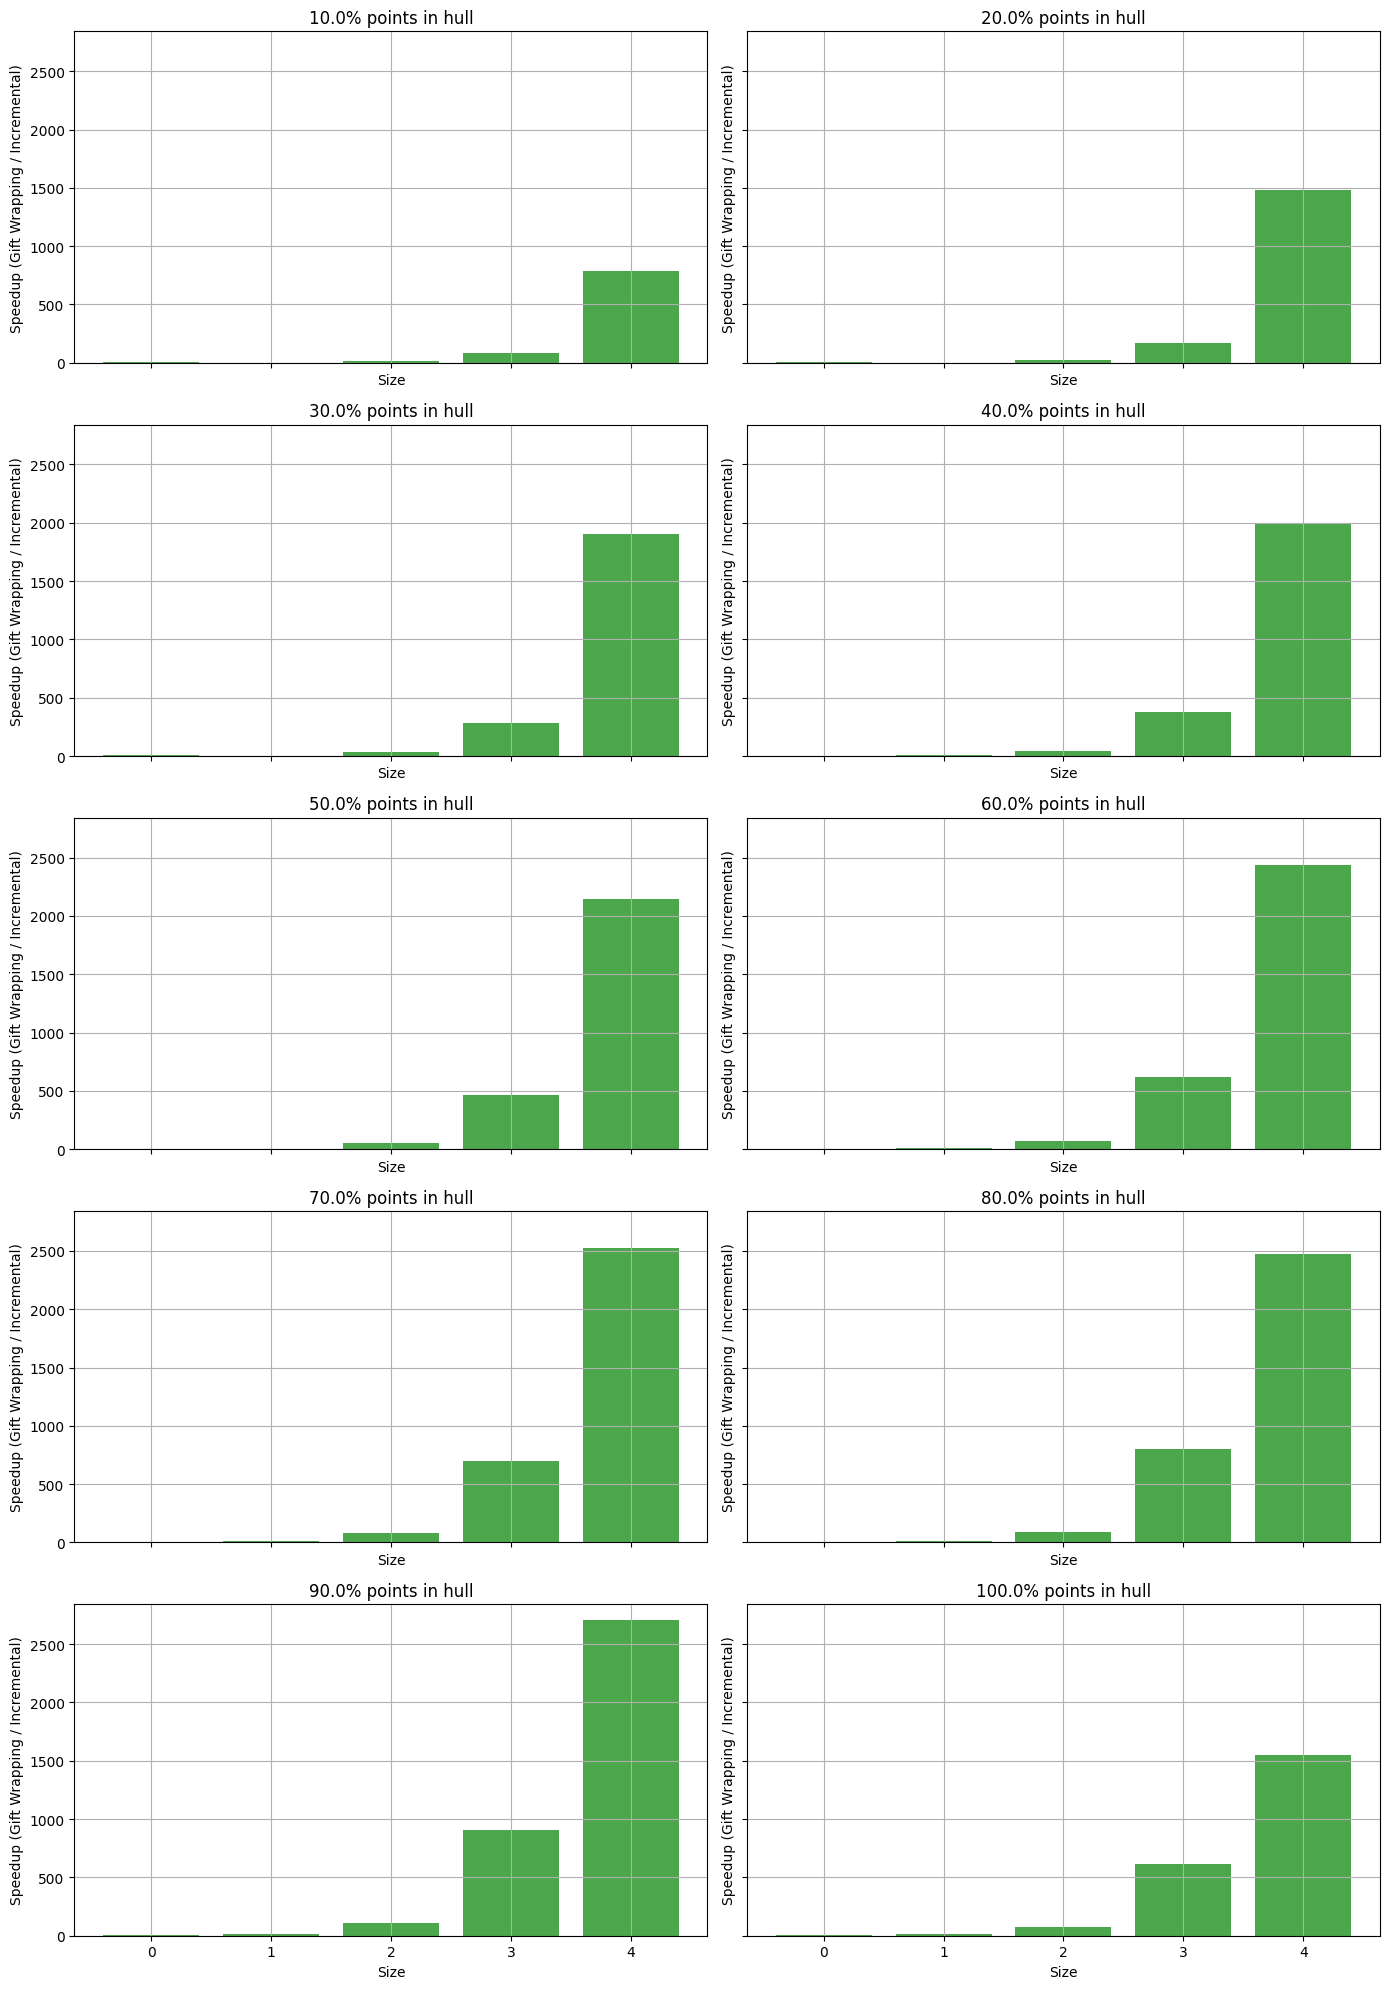

In [10]:
# Unir los dos DataFrames en uno solo para calcular el speedup
merged_df = pd.merge(circ_points_in_pcnt_avg, circ_points_gw_pcnt_avg, on=["size", "pcnt points in hull"], suffixes=('_in', '_gw'))

# Calcular el speedup
merged_df["speedup"] = merged_df["total time_gw"] / merged_df["total time_in"]
# print(merged_df["speedup"])

# Crear una figura con múltiples subgráficos
percentages = merged_df["pcnt points in hull"].unique()
num_percentages = len(percentages)
fig, axes = plt.subplots(nrows=(num_percentages + 1) // 2, ncols=2, figsize=(14, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Crear gráficos de barras por cada porcentaje
for ax, pcnt in zip(axes, percentages):
    subset = merged_df[merged_df["pcnt points in hull"] == pcnt]
    x = np.arange(len(subset.index))
    ax.bar(x, subset["speedup"], color='green', alpha=0.7)
    ax.set_title(f"{pcnt*100}% points in hull")
    ax.set_xlabel("Size")
    ax.set_ylabel("Speedup (Gift Wrapping / Incremental)")
    ax.grid(True)

# Eliminar cualquier gráfico vacío si el número de porcentajes es impar
for ax in axes[len(percentages):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# En algoritmo de Gift Wrapping: porcentaje de los tiempos con respecto al total 

Se cronometró el tiempo dedicado a la búsqueda del punto de menor X e Y, y luego se tomó el tiempo de operaciones para conocer la orientación entre 3 puntos.

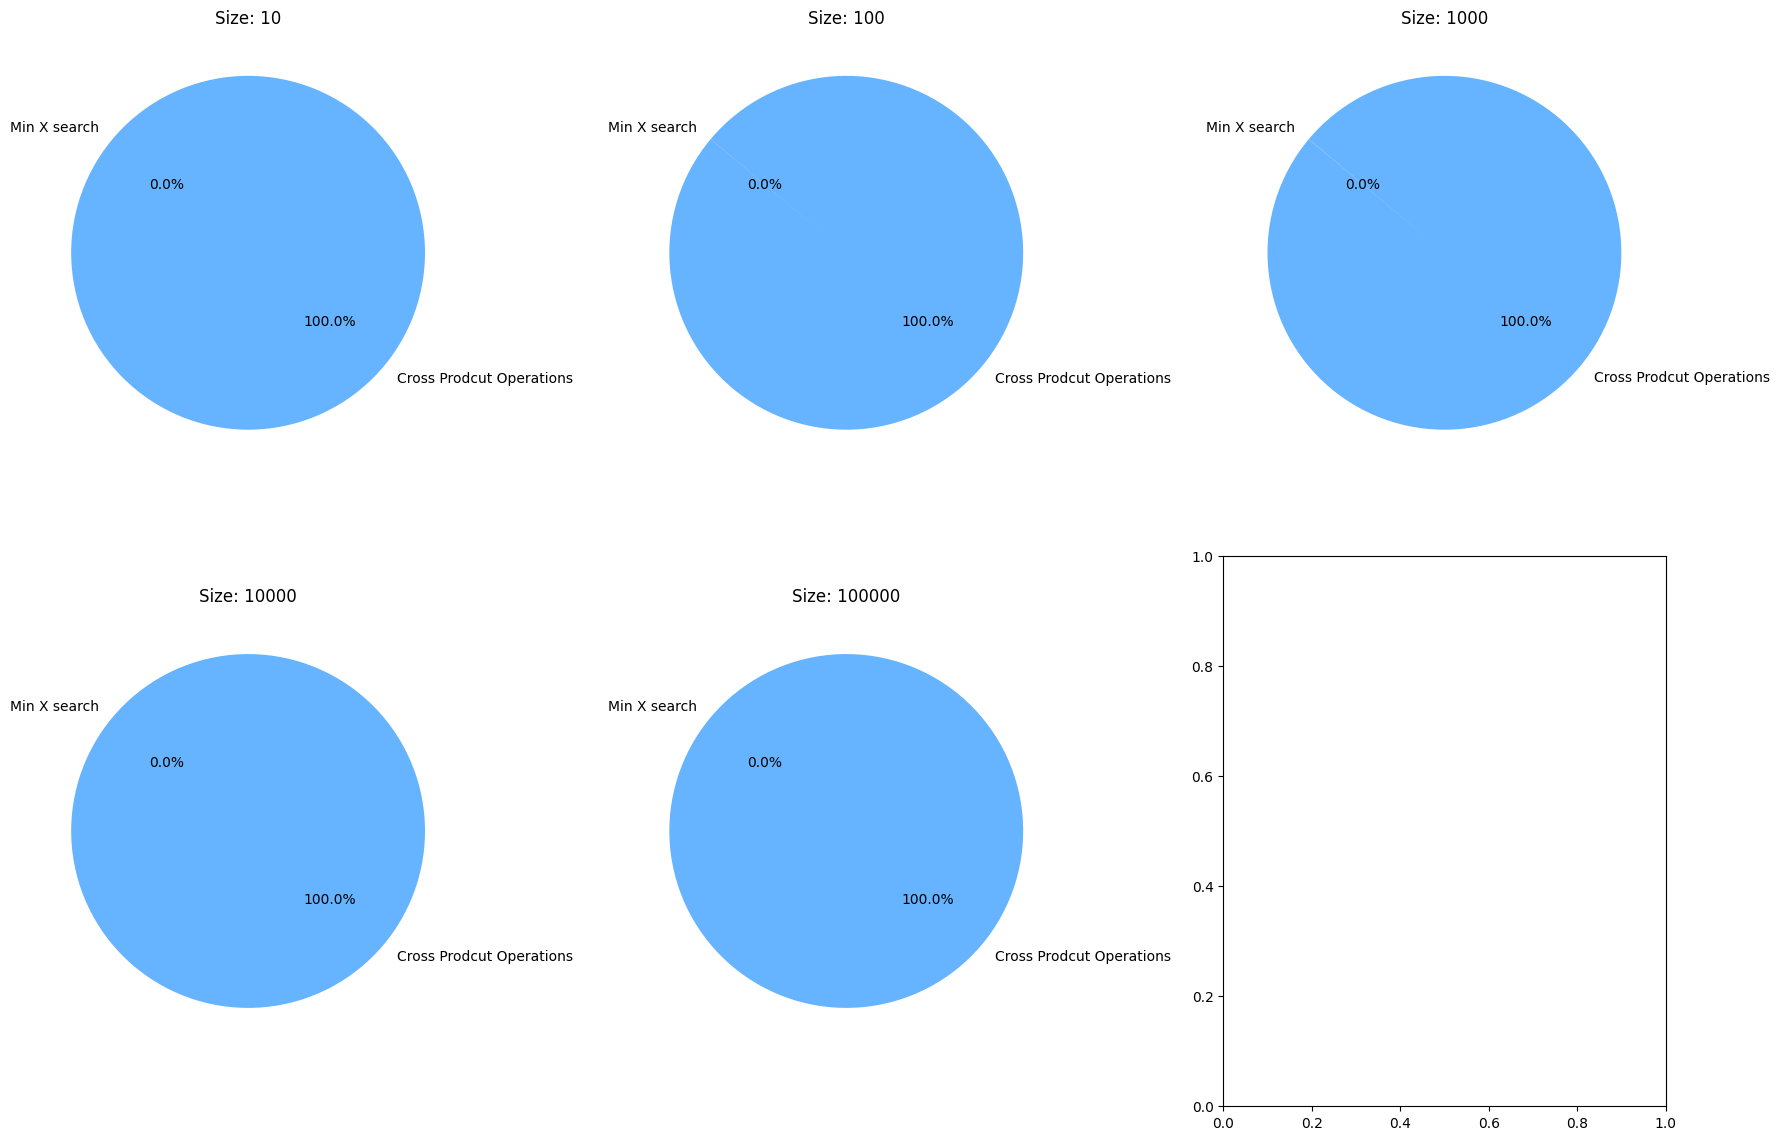

In [43]:
# Agrupar por tamaño y calcular los promedios
grouped = circ_points_gw.groupby("size").mean()

# Crear una figura para los gráficos de torta
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Ajusta nrows y ncols según sea necesario
axes = axes.flatten()

# Crear gráficos de torta por tamaño
for ax, (size, row) in zip(axes, grouped.iterrows()):
    min_search_time = row["minx_search_time"]
    cross_ops = row["cross prods time"]
    total_time = row["total time"]
    
    labels = ['Min X search', 'Cross Prodcut Operations']
    sizes = [min_search_time / total_time * 100, 
             cross_ops / total_time * 100]
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
    ax.set_title(f"Size: {size}")

plt.tight_layout()
plt.show()

# En algoritmo Incremental: porcentaje de los tiempos con respecto al total 

Se cronometró el tiempo dedicado al ordenamiento de los puntos, y luego se tomó el tiempo de creación del lower-hull y por último el del upper-hull. Se conocerán las relaciones de estos tiempos con respecto al total.

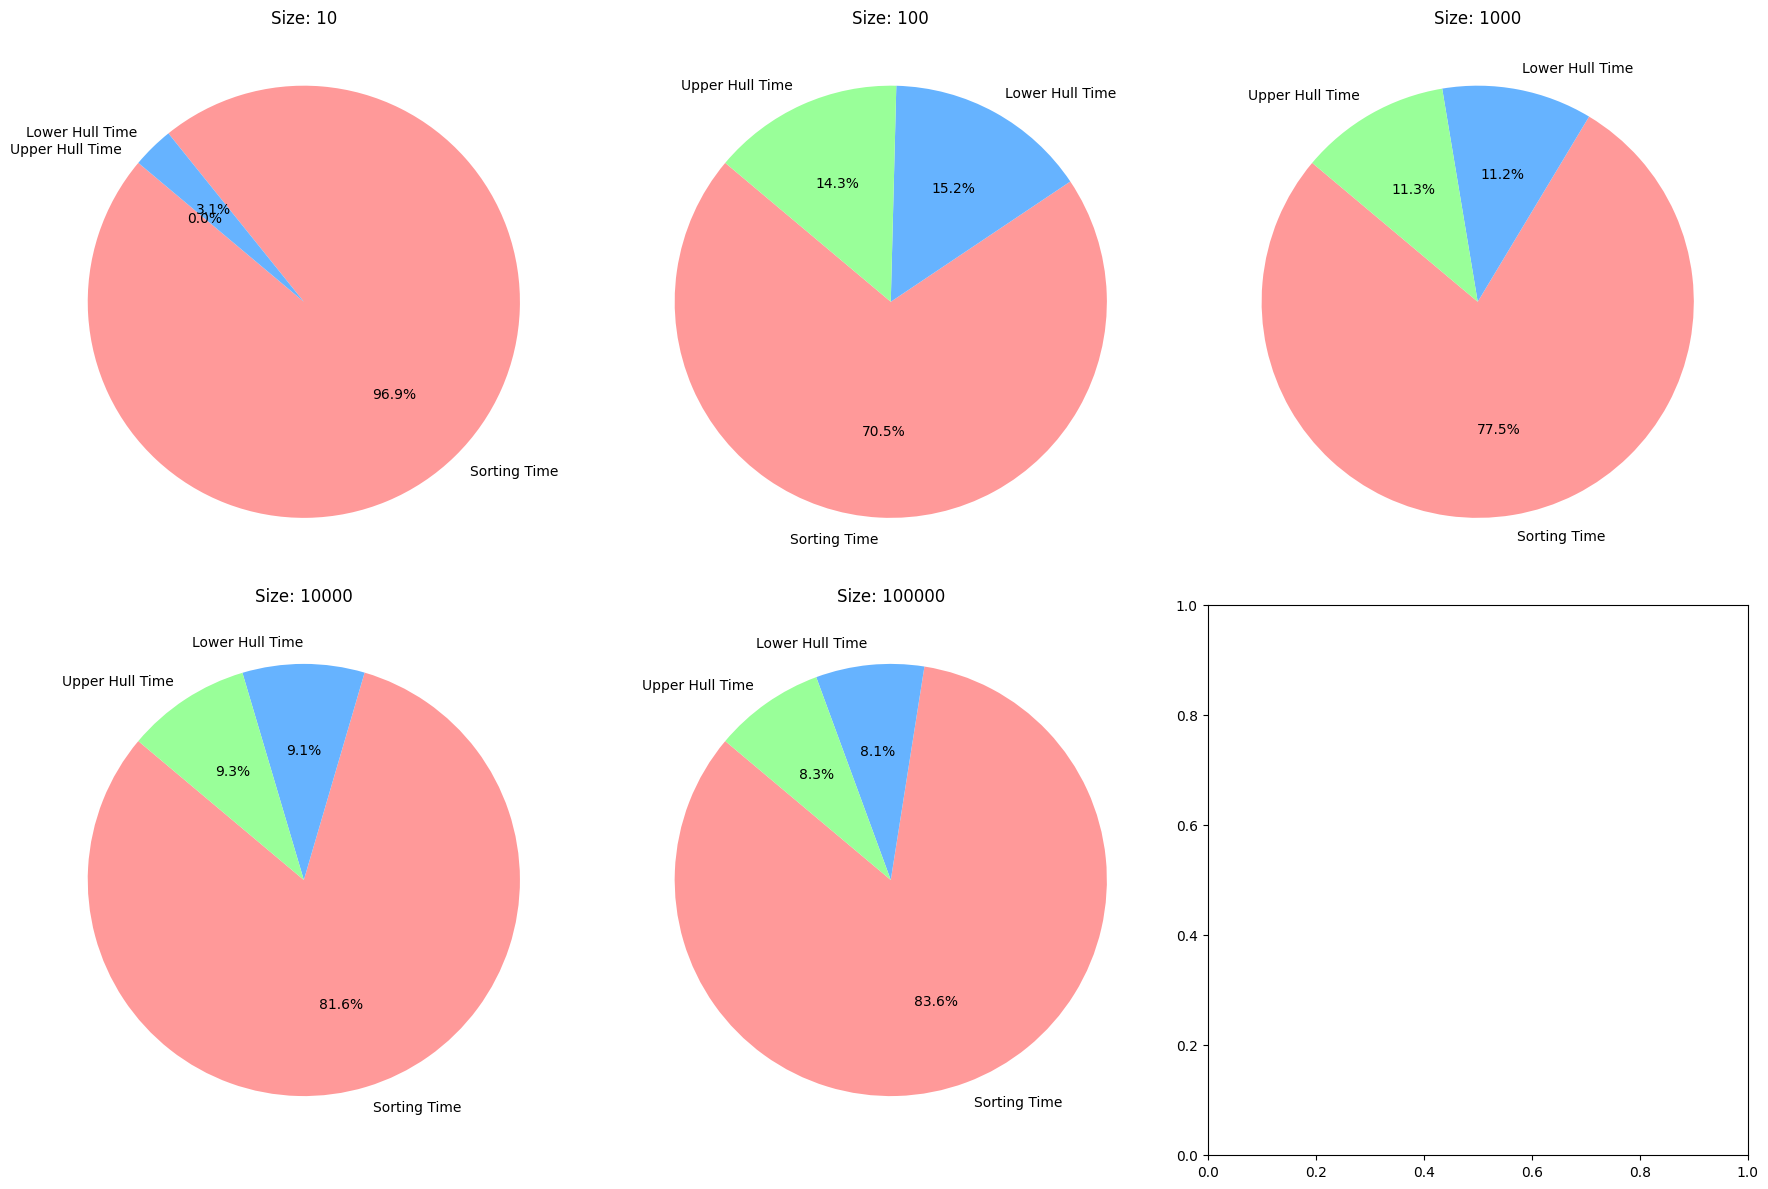

In [38]:
# Agrupar por tamaño y calcular los promedios
grouped = circ_points_in.groupby("size").mean()

# Crear una figura para los gráficos de torta
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Ajusta nrows y ncols según sea necesario
axes = axes.flatten()

# Crear gráficos de torta por tamaño
for ax, (size, row) in zip(axes, grouped.iterrows()):
    sorting_time = row["sorting time"]
    lower_hull_time = row["lower hull time"]
    upper_hull_time = row["upper hull size"]
    total_time = row["total time"]
    
    labels = ['Sorting Time', 'Lower Hull Time', 'Upper Hull Time']
    sizes = [sorting_time / total_time * 100, 
             lower_hull_time / total_time * 100, 
             upper_hull_time / total_time * 100]
    
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
    ax.set_title(f"Size: {size}")

plt.tight_layout()
plt.show()